In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [2]:
# Read in a image from torchvision
img = torchvision.io.read_image("/kaggle/input/imagefile/WhatsApp Image 2024-09-19 at 01.34.03.jpeg")
print(img.shape)

torch.Size([3, 698, 1280])


In [3]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [4]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled)

In [5]:
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.3412, 0.3529, 0.3333,  ..., 0.1882, 0.1804, 0.1765],
         [0.3373, 0.3569, 0.3451,  ..., 0.1882, 0.1804, 0.1765],
         [0.3333, 0.3608, 0.3569,  ..., 0.1922, 0.1804, 0.1804],
         ...,
         [0.5176, 0.5137, 0.5059,  ..., 0.5373, 0.5608, 0.5725],
         [0.4863, 0.5020, 0.5137,  ..., 0.5529, 0.5529, 0.5294],
         [0.4745, 0.4902, 0.5059,  ..., 0.5647, 0.5608, 0.5373]],

        [[0.6118, 0.6235, 0.6039,  ..., 0.4039, 0.3961, 0.3922],
         [0.6078, 0.6275, 0.6157,  ..., 0.4039, 0.3961, 0.3922],
         [0.5961, 0.6235, 0.6196,  ..., 0.4039, 0.3961, 0.3961],
         ...,
         [0.6824, 0.6784, 0.6667,  ..., 0.6431, 0.6549, 0.6667],
         [0.6510, 0.6706, 0.6745,  ..., 0.6667, 0.6549, 0.6275],
         [0.6431, 0.6588, 0.6667,  ..., 0.6784, 0.6627, 0.6353]],

        [[0.6392, 0.6510, 0.6314,  ..., 0.3137, 0.3059, 0.3020],
         [0.6353, 0.6549, 0.6431,  ..., 0.3137, 0.3059, 0.3020],
         [0.6196, 0.6471, 0.6431,  ..., 0.3137, 0.3059, 0.

In [6]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 300, 300, 300, 300)
crop.shape

torch.Size([3, 300, 300])

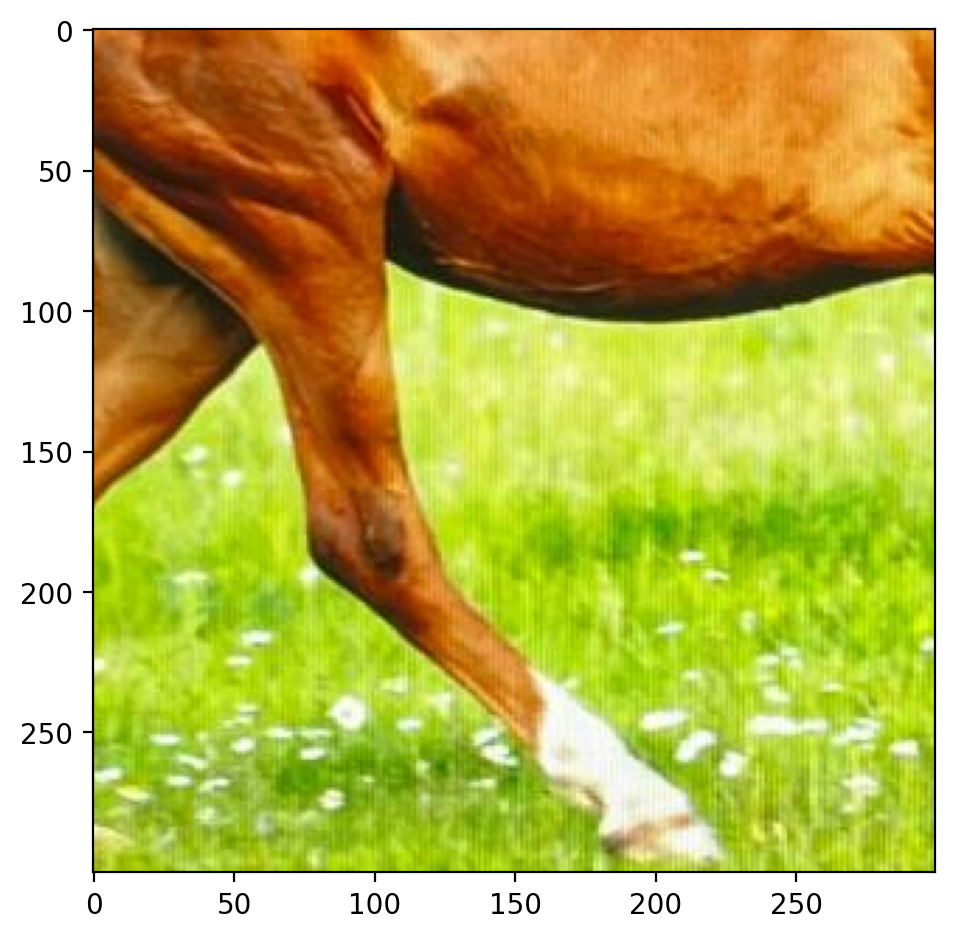

In [7]:
    plt.imshow(crop.cpu().permute(1, 2, 0))
    plt.tight_layout()

In [8]:
crop = crop.to(device)

In [9]:
# Get the dimensions of the image tensor
num_channels, height, width = crop.shape
print(num_channels, height, width)

3 300 300


In [10]:
num_channels, height, width = 2, 3, 4

    
# Create a 2D grid of (x,y) coordinates
w_coords = torch.arange(width).repeat(height, 1)
h_coords = torch.arange(height).repeat(width, 1).t()
w_coords = w_coords.reshape(-1)
h_coords = h_coords.reshape(-1)

# Combine the x and y coordinates into a single tensor
X = torch.stack([h_coords, w_coords], dim=1).float()

In [11]:
X.shape

torch.Size([12, 2])

In [12]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)
    
    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """
    
    num_channels, height, width = img.shape
    
    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [13]:
dog_X, dog_Y = create_coordinate_map(crop)

dog_X.shape, dog_Y.shape

(torch.Size([90000, 2]), torch.Size([90000, 3]))

In [14]:
# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())

# Scale the X coordinates
dog_X_scaled = scaler_X.transform(dog_X.cpu())

# Move the scaled X coordinates to the GPU
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)

# Set to dtype float32
dog_X_scaled = dog_X_scaled.float()

In [15]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        
    def forward(self, x):
        return self.linear(x)

In [16]:
net = LinearModel(2, 3)
net.to(device)

LinearModel(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

In [17]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)
        
        
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [18]:
train(net, 0.01, dog_X_scaled, dog_Y, 1000)

Epoch 0 loss: 0.308912
Epoch 100 loss: 0.035286
Epoch 200 loss: 0.035267
Epoch 300 loss: 0.035267
Epoch 400 loss: 0.035267
Epoch 500 loss: 0.035267
Epoch 600 loss: 0.035267
Epoch 700 loss: 0.035267
Epoch 800 loss: 0.035267
Epoch 900 loss: 0.035267


0.035267174243927

In [19]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        #outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")
    

    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")
    
    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

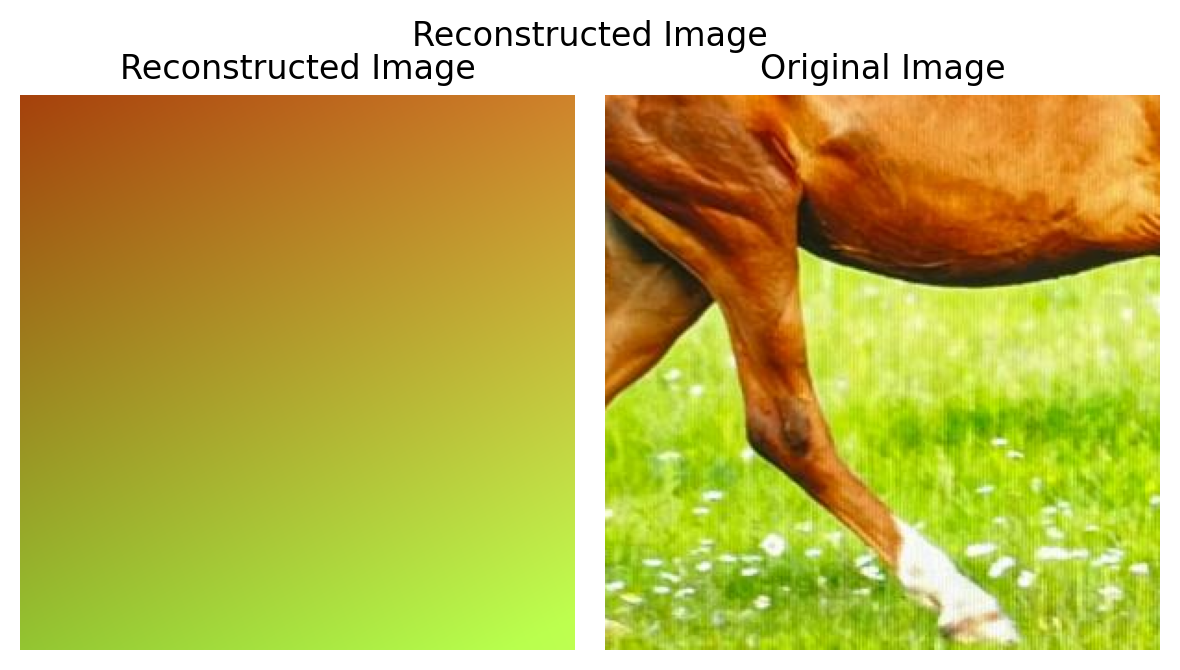

In [20]:
plot_reconstructed_and_original_image(crop, net, dog_X_scaled, title="Reconstructed Image")

In [21]:
# create RFF features
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

In [22]:
X_rff = create_rff_features(dog_X_scaled, 37500, 0.008)

In [23]:
X_rff.shape

torch.Size([90000, 37500])

In [24]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)

train(net, 0.005, X_rff, dog_Y, 2400)

Epoch 0 loss: 0.354601
Epoch 100 loss: 0.055393
Epoch 200 loss: 0.015378
Epoch 300 loss: 0.009637
Epoch 400 loss: 0.007070
Epoch 500 loss: 0.005402
Epoch 600 loss: 0.004205
Epoch 700 loss: 0.003299
Epoch 800 loss: 0.002593
Epoch 900 loss: 0.002038
Epoch 1000 loss: 0.001602
Epoch 1100 loss: 0.001262
Epoch 1200 loss: 0.001001
Epoch 1300 loss: 0.000804
Epoch 1400 loss: 0.000657
Epoch 1500 loss: 0.000550
Epoch 1600 loss: 0.000473
Epoch 1700 loss: 0.000420
Epoch 1800 loss: 0.000382
Epoch 1900 loss: 0.000357
Epoch 2000 loss: 0.000341
Epoch 2100 loss: 0.000329
Epoch 2200 loss: 0.000322
Epoch 2300 loss: 0.000317


0.0003140627813991159

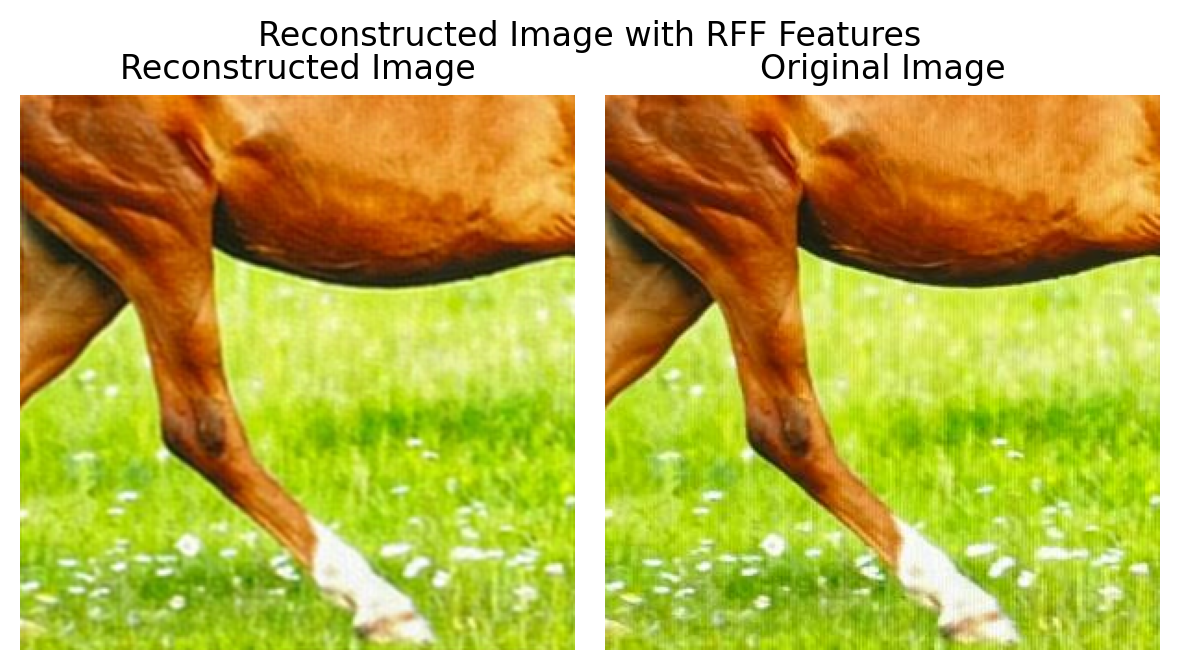

In [25]:
plot_reconstructed_and_original_image(crop, net, X_rff, title="Reconstructed Image with RFF Features")

In [26]:
X_rff.shape

torch.Size([90000, 37500])

In [27]:
crop.shape

torch.Size([3, 300, 300])

In [28]:
w = 100
scale=2
torch.arange(0, w, 1/scale)

tensor([ 0.0000,  0.5000,  1.0000,  1.5000,  2.0000,  2.5000,  3.0000,  3.5000,
         4.0000,  4.5000,  5.0000,  5.5000,  6.0000,  6.5000,  7.0000,  7.5000,
         8.0000,  8.5000,  9.0000,  9.5000, 10.0000, 10.5000, 11.0000, 11.5000,
        12.0000, 12.5000, 13.0000, 13.5000, 14.0000, 14.5000, 15.0000, 15.5000,
        16.0000, 16.5000, 17.0000, 17.5000, 18.0000, 18.5000, 19.0000, 19.5000,
        20.0000, 20.5000, 21.0000, 21.5000, 22.0000, 22.5000, 23.0000, 23.5000,
        24.0000, 24.5000, 25.0000, 25.5000, 26.0000, 26.5000, 27.0000, 27.5000,
        28.0000, 28.5000, 29.0000, 29.5000, 30.0000, 30.5000, 31.0000, 31.5000,
        32.0000, 32.5000, 33.0000, 33.5000, 34.0000, 34.5000, 35.0000, 35.5000,
        36.0000, 36.5000, 37.0000, 37.5000, 38.0000, 38.5000, 39.0000, 39.5000,
        40.0000, 40.5000, 41.0000, 41.5000, 42.0000, 42.5000, 43.0000, 43.5000,
        44.0000, 44.5000, 45.0000, 45.5000, 46.0000, 46.5000, 47.0000, 47.5000,
        48.0000, 48.5000, 49.0000, 49.50

In [29]:
def create_coordinate_map(img, scale=1):
    """
    img: torch.Tensor of shape (num_channels, height, width)
    
    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """
    
    num_channels, height, width = img.shape
    
    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(0, width,  1/scale).repeat(int(height*scale), 1)
    h_coords = torch.arange(0, height, 1/scale).repeat(int(width*scale), 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [30]:
num_channels, height, width = crop.shape
net.eval()
with torch.no_grad():
    outputs = net(X_rff)
    outputs = outputs.reshape(num_channels, height, width)

In [31]:
Pred = create_coordinate_map(outputs, scale=1)
Pred

(tensor([[  0.,   0.],
         [  0.,   1.],
         [  0.,   2.],
         ...,
         [299., 297.],
         [299., 298.],
         [299., 299.]], device='cuda:0'),
 tensor([[0.8281, 0.5605, 0.5982],
         [0.5039, 0.3385, 0.7748],
         [0.2098, 0.0215, 0.0022],
         ...,
         [0.7724, 0.7553, 0.6374],
         [0.8727, 0.8803, 0.7946],
         [0.3184, 0.2150, 0.0808]], device='cuda:0'))

In [32]:
Crop = create_coordinate_map(crop, scale=1)
Crop

(tensor([[  0.,   0.],
         [  0.,   1.],
         [  0.,   2.],
         ...,
         [299., 297.],
         [299., 298.],
         [299., 299.]], device='cuda:0'),
 tensor([[0.8314, 0.4863, 0.2039],
         [0.8392, 0.4941, 0.2118],
         [0.8196, 0.4745, 0.1922],
         ...,
         [0.6784, 0.8314, 0.1216],
         [0.5843, 0.7451, 0.0314],
         [0.6471, 0.8078, 0.0941]], device='cuda:0'))

In [33]:
from torch import nn
criterion = nn.MSELoss()
loss = torch.sqrt(criterion(Pred[1], Crop[1]))
loss.item()

0.4727129340171814

In [34]:
from torchmetrics.image import PeakSignalNoiseRatio
psnr = PeakSignalNoiseRatio().to(device)
psnr_db = psnr(Pred[1], Crop[1])
psnr_db.item()

6.508049964904785